In [1]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

## Analysing model training

In [3]:
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import data_util
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(data_util)
from value_decoder import ValueDecoder
from decoder import Decoder
from encoder import Encoder


In [4]:
import torch
import numpy as np
import sympy as sp
from parsing import prods_to_prefix, logits_to_prefix, logits_to_prods
from data_util import load_dataset, calc_priors_and_means, create_dataloader, load_wandb_model, create_dataloader_from_wandb, data_from_loader
from debug_util import plot_onehot
from matplotlib import pyplot as plt
torch.manual_seed(41)
torch.set_grad_enabled(False)

In [4]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in vae_model: {total_params}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in vae_model: {trainable_params}")
encoder_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Number of parameters in encoder: {encoder_params}")
decoder_params = sum(p.numel() for p in model.decoder.parameters())
print(f"Number of parameters in decoder: {decoder_params}")
value_decoder_params = sum(p.numel() for p in model.value_decoder.parameters())
print(f"Number of parameters in value_decoder: {value_decoder_params}")


Total number of parameters in vae_model: 700046
Total number of trainable parameters in vae_model: 700046
Number of parameters in encoder: 93024
Number of parameters in decoder: 46282
Number of parameters in value_decoder: 560740


## Syntax decoding accuracy

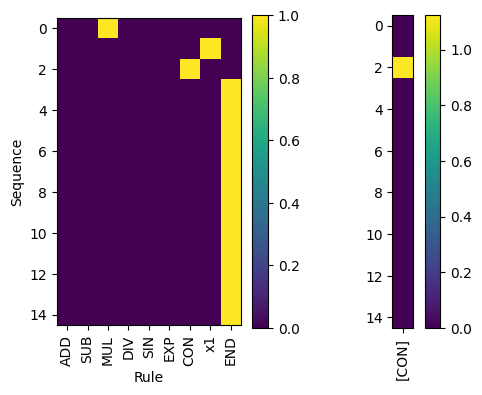

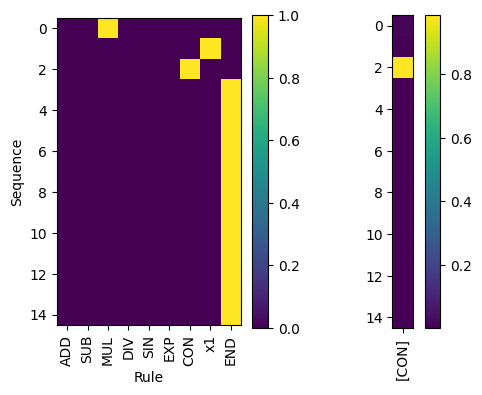

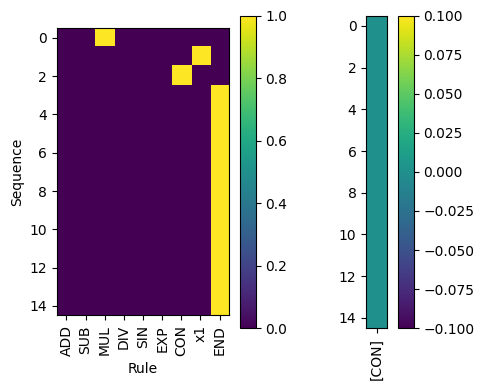

In [11]:
x = data_from_loader(test_loader, 'x', idx=10)
logits, values_pred = model.forward(x)

plot_onehot(x.squeeze(0).T.detach().numpy(), syntax_cats, figsize=(5, 4))
plot_onehot(logits.squeeze(0).detach().numpy(), syntax_cats, apply_softmax=True, figsize=(5, 4))


# Create a matrix where the argmax column is 1 and everything else is 0 for each row
logits_numpy = logits.squeeze(0).detach().numpy().copy()
argmax_matrix = np.zeros_like(logits_numpy)
argmax_indices = np.argmax(logits_numpy, axis=1)
argmax_matrix[np.arange(logits_numpy.shape[0]), argmax_indices] = 1

# Plot the argmax matrix
plot_onehot(argmax_matrix, syntax_cats, apply_softmax=False, figsize=(5, 4))


## Value decoding accuracy

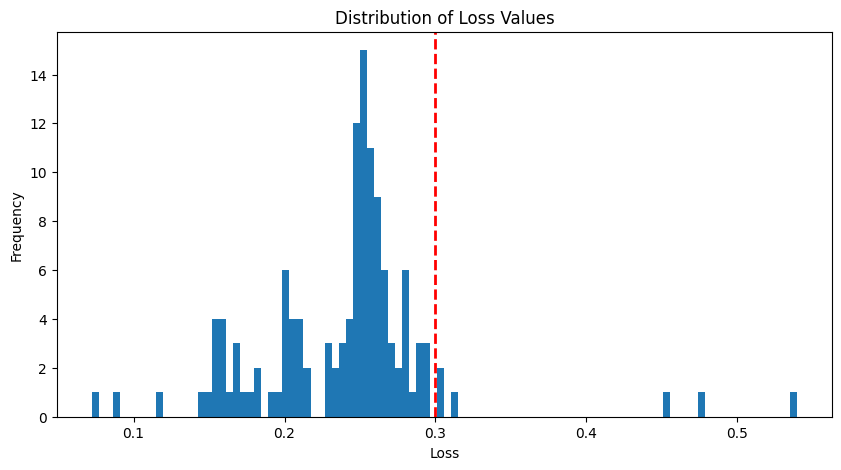

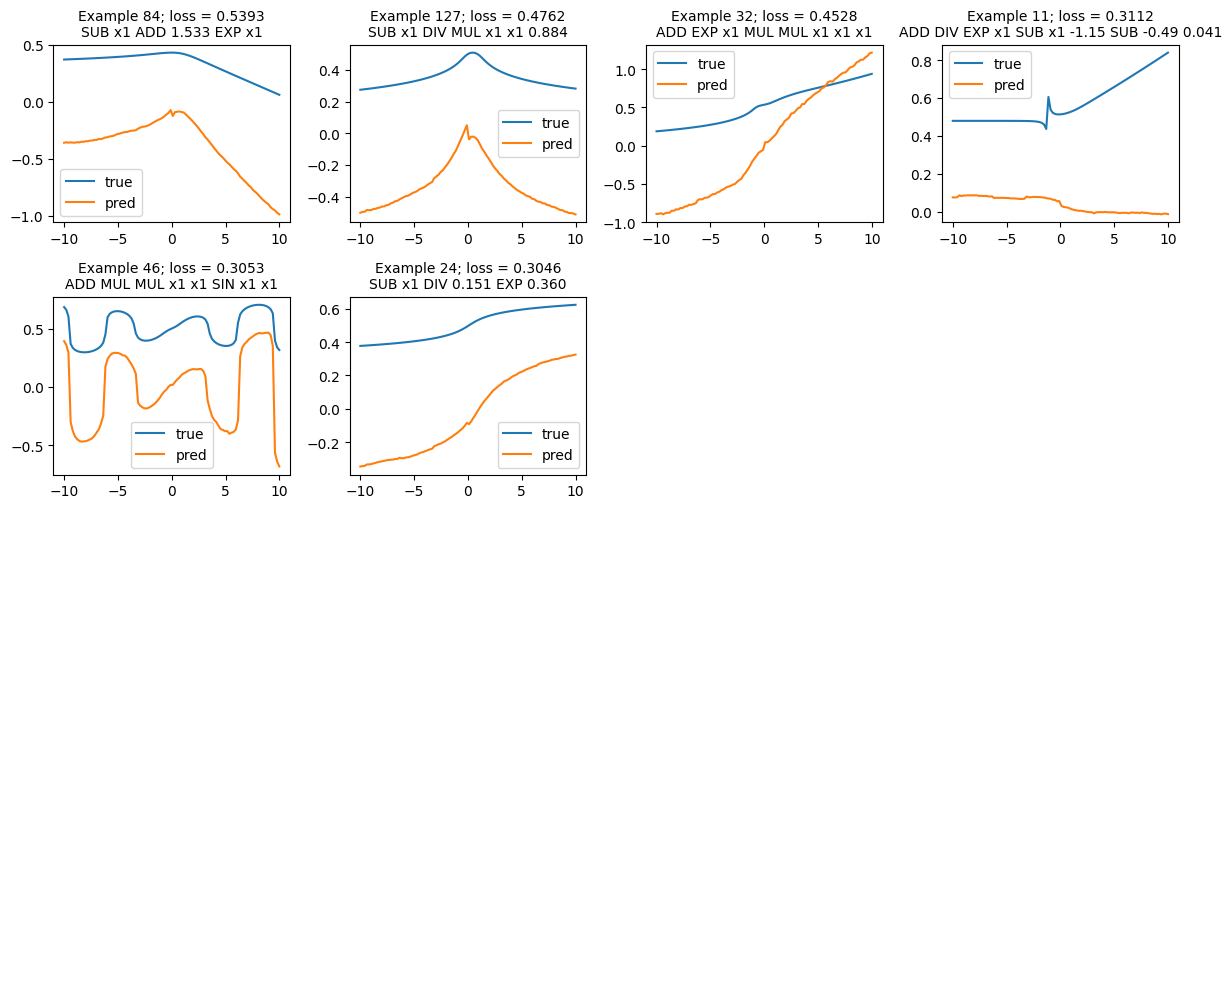

In [21]:
from grammar import GCFG

i = 2
N = 128
data_loader = test_loader
x = data_from_loader(data_loader, 'x', idx=range(i, i+N))
values_true = data_from_loader(data_loader, 'values', idx=range(i, i+N))

# Calculate predictions

_, values_pred = model.forward(x)

# Calculate loss for each example
mse = torch.nn.MSELoss(reduction='none')
loss = mse(values_pred, values_true).mean(axis=1)

# Set threshold (e.g., 1 standard deviation above mean)
threshold = loss.mean() + 1 * loss.std()

# Sort indices by loss in descending order
sorted_indices = torch.argsort(loss, descending=True)

# Plot histogram of loss values
plt.figure(figsize=(10, 5))
plt.hist(loss.detach().numpy(), bins=100)
plt.axvline(threshold.detach().numpy(), color='r', linestyle='dashed', linewidth=2)
plt.title('Distribution of Loss Values')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

# Plot function values for highest-loss examples above threshold
num_plots = 16  # Limit to 16 plots
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 2.5 * num_rows), squeeze=False)
fig.tight_layout(pad=5.0)

plot_count = 0
for i in range(len(sorted_indices)):
    if plot_count >= num_plots:
        break
    
    idx = sorted_indices[i]
    if loss[idx] < threshold:
        continue
    
    row = plot_count // num_cols
    col = plot_count % num_cols
    
    y_true = values_true[idx, ...]
    y_pred = values_pred[idx, ...]
    
    # Plot function values
    axs[row, col].plot(val_x, y_true.squeeze().detach().numpy(), label='true')
    axs[row, col].plot(val_x, y_pred.squeeze().detach().numpy(), label='pred')
    axs[row, col].legend()
    prods = logits_to_prods(x[idx, ...].squeeze(0).T, GCFG, sample=False)
    prefix = [s[:min(5, len(s))] for s in prods_to_prefix(prods)]
    eq_str = ' '.join(prefix)
    axs[row, col].set_title(f'Example {idx.item()}; loss = {loss[idx].item():.4f}\n{eq_str}', fontsize=10)
    
    plot_count += 1

# Hide any unused subplots
for i in range(plot_count, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

## Contrastive loss

In [15]:
data_path = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
dataset_name = 'dataset_240910_2'
cfg_path = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/src/model/config.json'

cfg_dict, cfg = load_config(cfg_path)
train_loader, valid_loader, info = create_dataloader(data_path, dataset_name, cfg, num_workers=1)

Using fallback value for model.value_decoder.size_lin1: 64
{'z_slice': [0, -1], 'size_lin1': 64, 'conv_size': 'large'}
Unexpected key in ValueDecoderConfig: size_lin1


In [18]:
x, y_syntax, y_consts, y_values = None, None, None, None
for batch in train_loader:
    x, y_syntax, y_consts, y_values = batch
    break

In [32]:
l2_dist = torch.nn.PairwiseDistance(p=2)

values_dist = l2_dist(y_values.unsqueeze(1), y_values.unsqueeze(0))

<module 'model' from '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/src/model/model.py'>

In [29]:
from torch.nn import functional as F



# Compute cosine similarity matrix
cos_sim = F.cosine_similarity(y_values.unsqueeze(1), y_values.unsqueeze(0), dim=2)
L1_sim = l1_dist(y_values.unsqueeze(1), y_values.unsqueeze(0))

print("Cosine similarity matrix shape:", cos_sim.shape)
print("Sample of cosine similarity matrix:")
print(cos_sim[:5, :5])  # Print a 5x5 sample of the matrix

Cosine similarity matrix shape: torch.Size([128, 128])
Sample of cosine similarity matrix:
tensor([[ 1.0000,  0.2224, -0.7416, -0.6884,  0.0698],
        [ 0.2224,  1.0000, -0.1704,  0.0101, -0.5882],
        [-0.7416, -0.1704,  1.0000,  0.9607, -0.1001],
        [-0.6884,  0.0101,  0.9607,  1.0000, -0.1391],
        [ 0.0698, -0.5882, -0.1001, -0.1391,  1.0000]])


In [31]:
L1_sim[:5, :5]

tensor([[1.0000e-04, 4.7600e+00, 1.6918e+01, 2.0903e+01, 5.3049e+00],
        [4.7600e+00, 1.0000e-04, 1.4492e+01, 1.7480e+01, 6.8604e+00],
        [1.6918e+01, 1.4492e+01, 1.0000e-04, 5.3365e+00, 1.3998e+01],
        [2.0903e+01, 1.7480e+01, 5.3365e+00, 1.0000e-04, 1.8496e+01],
        [5.3048e+00, 6.8603e+00, 1.3998e+01, 1.8496e+01, 1.0000e-04]])

# Plots for presentation

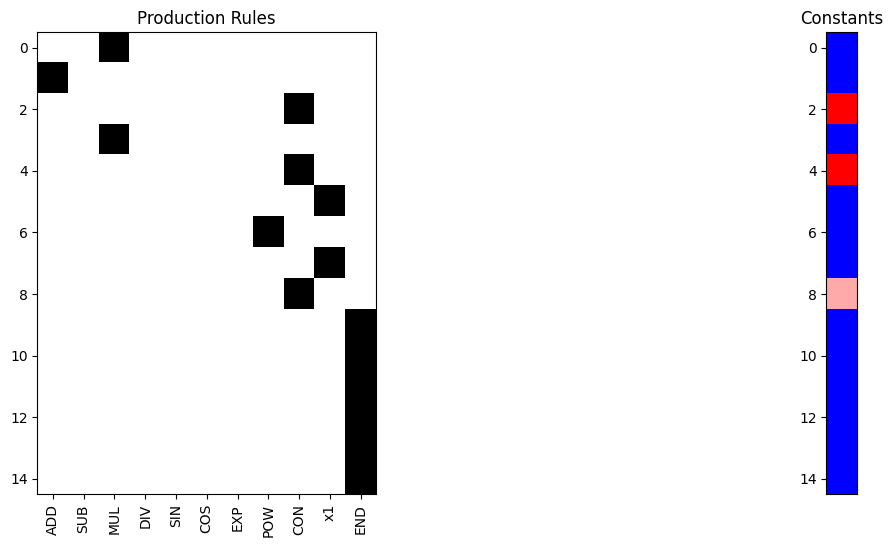

In [19]:
expr = "(3+3*x)*x**2"

expr_prefix = ['MUL', 'ADD', 'CON', 'MUL', 'CON', 'x1', 'POW', 'x1', 'CON']

consts = [0, 0, 3, 0, 3, 0, 0, 0, 2]

rules = ['ADD', 'SUB', 'MUL', 'DIV', 'SIN', 'COS', 'EXP', 'POW', 'CON', 'x1', 'END']

expr_prefix = expr_prefix + ['END']*(15-len(expr_prefix))
consts = consts + [0]*(15-len(consts))


mat = np.zeros((15, 11))
for i, rule in enumerate(expr_prefix):
    mat[i, rules.index(rule)] = 1


plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(mat, cmap='binary')
plt.xticks(range(len(rules)), rules, rotation=90)
plt.title('Production Rules')

plt.subplot(122, sharey=plt.gca())
plt.imshow(np.array(consts).reshape(-1,1), cmap='bwr')
plt.xticks([])
plt.title('Constants')

plt.subplots_adjust(wspace=0.05)
plt.show()
